In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
# Step 1: Register your custom font with Matplotlib
font_path = '/Users/henrismidt/Documents/Informatik/Fonts/libertinus/LibertinusSerif-Regular.otf'
font_manager.fontManager.addfont(font_path)  # Register the font with Matplotlib

# Step 2: Update Matplotlib's RC settings to use your font by default
plt.rcParams['font.family'] = 'Libertinus Serif'

In [5]:
import pandas as pd

# Replace 'path_to_csv' with the actual path to your CSV file
file_path = 'Data/metadata_for_preprocessed_files.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(data.head())


   Unnamed: 0             ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV  \
0           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
1           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
2           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
3           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
4           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   

     ASF  Delay                                               path  
0  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...  
1  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...  
2  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...  
3  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...  
4  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...  


In [6]:
# Check basic information about the DataFrame
print(data.info())

# Check for missing values in the 'CDR' column
print(f'Number of Null entries: {data["CDR"].isnull().sum()}')

# Get unique values in 'CDR' column to understand the distribution
print(f'Different values for CDR: {data["CDR"].unique()}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153472 entries, 0 to 153471
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  153472 non-null  int64  
 1   ID          153472 non-null  object 
 2   M/F         153472 non-null  object 
 3   Hand        153472 non-null  object 
 4   Age         153472 non-null  int64  
 5   Educ        82720 non-null   float64
 6   SES         76032 non-null   float64
 7   MMSE        82720 non-null   float64
 8   CDR         153472 non-null  float64
 9   eTIV        153472 non-null  int64  
 10  nWBV        153472 non-null  float64
 11  ASF         153472 non-null  float64
 12  Delay       7040 non-null    float64
 13  path        153472 non-null  object 
dtypes: float64(7), int64(3), object(4)
memory usage: 16.4+ MB
None
Number of Null entries: 0
Different values for CDR: [0.  0.5 1.  2. ]


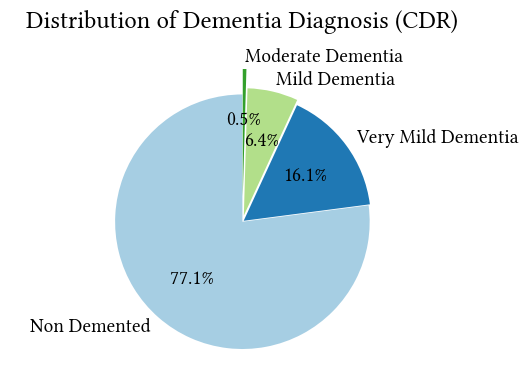

In [48]:
# Mapping CDR scores to descriptive labels
cdr_labels = {0.0: 'Non Demented', 0.5: 'Very Mild Dementia', 1.0: 'Mild Dementia', 2.0: 'Moderate Dementia'}
data['Dementia Status'] = data['CDR'].map(cdr_labels)

# Preparing data for plotting
plot_data = data['Dementia Status'].value_counts()

# Configuring the pie chart to avoid label overlap
explode = (0, 0.0125, 0.05, 0.2)  # Only explode the first slice if it's the smallest
plt.figure(figsize=(6, 4))
plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', startangle=90, explode=explode, colors=plt.cm.Paired(range(len(plot_data))), textprops={'fontsize': 14})
plt.title('Distribution of Dementia Diagnosis (CDR)', fontsize=18, pad=20)
plt.axis('equal')

# Adding a legend
# plt.legend(plot_data.index, title="Dementia Status", title_fontsize='13', fontsize='12', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the plot
plt.show()


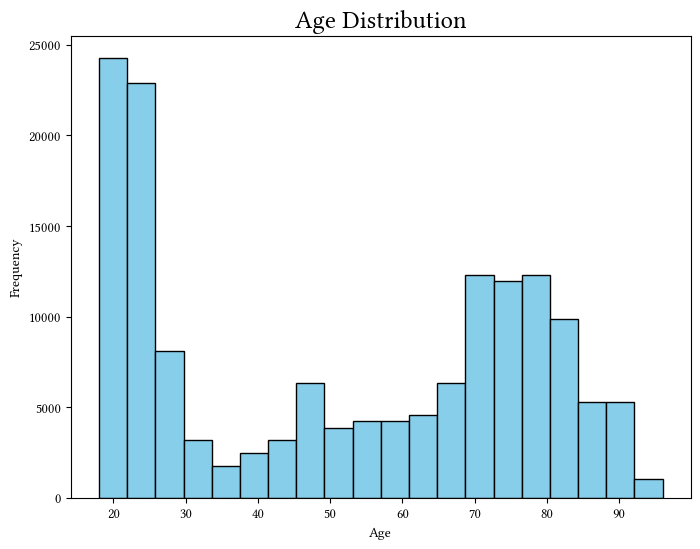

In [50]:
# Histogram for Age
plt.figure(figsize=(8, 6))
plt.hist(data['Age'], bins=20, color='skyblue', edgecolor='black')  # Adjust bins as necessary
plt.title('Age Distribution', fontsize=18)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


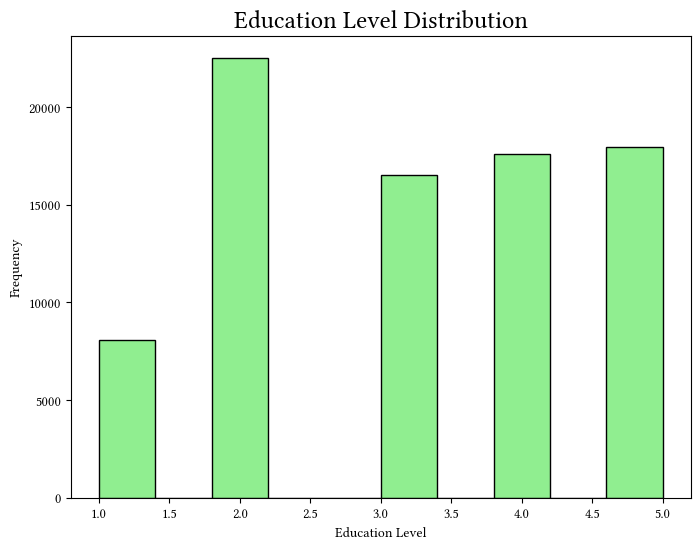

In [51]:
# Histogram for Education Level
plt.figure(figsize=(8, 6))
plt.hist(data['Educ'], bins=10, color='lightgreen', edgecolor='black')  # Adjust bins as necessary
plt.title('Education Level Distribution', fontsize=18)
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.show()


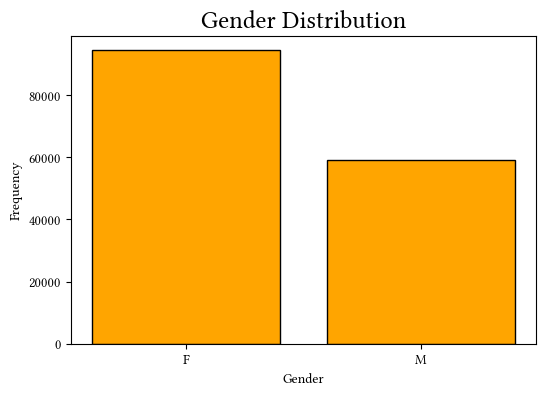

In [52]:
# Bar Chart for Gender Distribution
gender_counts = data['M/F'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(gender_counts.index, gender_counts, color='orange', edgecolor='black')
plt.title('Gender Distribution', fontsize=18)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()


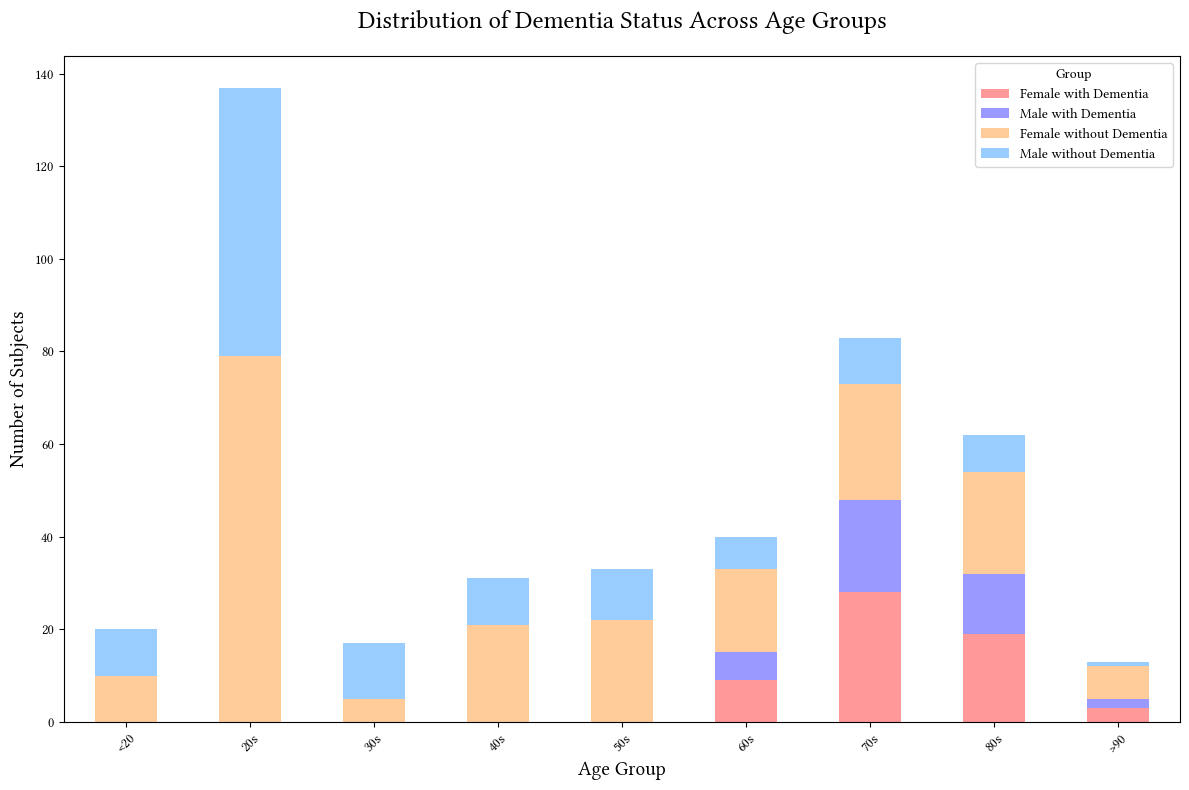

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is loaded and includes 'ID', 'CDR', 'Age', 'M/F' columns
# Mapping CDR to Dementia Status
cdr_labels = {0.0: 'Non Demented', 0.5: 'Very Mild Dementia', 1.0: 'Mild Dementia', 2.0: 'Moderate Dementia'}
data['Dementia Status'] = data['CDR'].map(cdr_labels)

# Removing duplicates
data = data.drop_duplicates(subset=['ID', 'Age', 'M/F', 'Dementia Status'])

# Bin ages
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '>90']
data['Age Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Preparing data for stacked bar chart
plot_data = data.groupby(['Age Group', 'M/F', 'Dementia Status']).size().unstack(fill_value=0)

# Sum up the dementia statuses for males and females
plot_data = plot_data.groupby(['Age Group', 'M/F']).sum()

# Separate the data by gender and condition
female_dementia = plot_data.xs('F', level='M/F')[['Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']].sum(axis=1)
male_dementia = plot_data.xs('M', level='M/F')[['Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']].sum(axis=1)
female_nondementia = plot_data.xs('F', level='M/F')['Non Demented']
male_nondementia = plot_data.xs('M', level='M/F')['Non Demented']

# Stack the data for plotting
final_plot_data = pd.DataFrame({
    'Female with Dementia': female_dementia,
    'Male with Dementia': male_dementia,
    'Female without Dementia': female_nondementia,
    'Male without Dementia': male_nondementia
})

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 8))
final_plot_data.plot(kind='bar', stacked=True, ax=ax, color=['#ff9999','#9999ff','#ffcc99','#99ccff'])

ax.set_title('Distribution of Dementia Status Across Age Groups', fontsize=18, pad=20)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_ylabel('Number of Subjects', fontsize=14)
ax.legend(title='Group')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



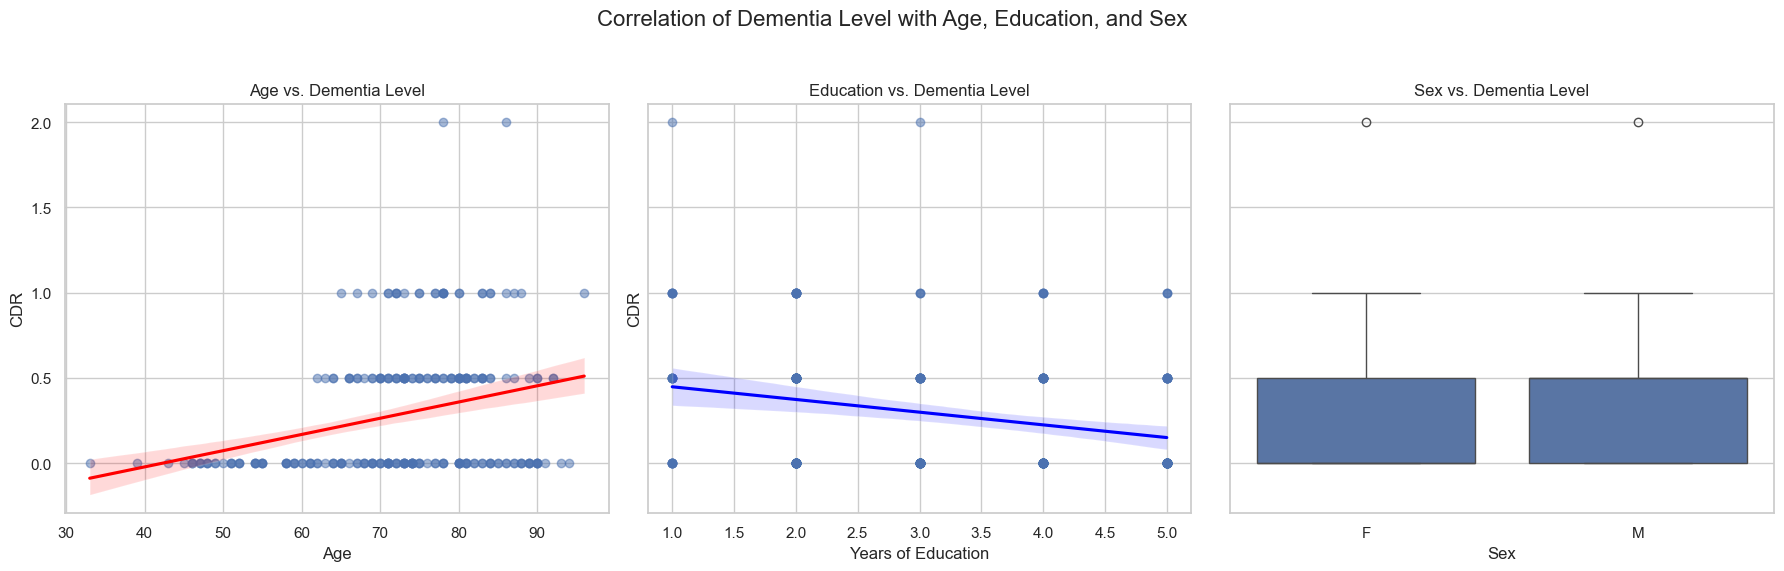

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drop rows with NaN values in these columns
data_without_nans = data.dropna(subset=['Age', 'Educ', 'CDR', 'M/F'])

# Setting the plot style
sns.set(style="whitegrid")

# Creating a figure to hold the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Correlation of Dementia Level with Age, Education, and Sex', fontsize=16)

# Plot 1: Age vs. Dementia Level
sns.regplot(ax=axes[0], x='Age', y='CDR', data=data_without_nans, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0].set_title('Age vs. Dementia Level')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('CDR')

# Plot 2: Education vs. Dementia Level
sns.regplot(ax=axes[1], x='Educ', y='CDR', data=data_without_nans, scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
axes[1].set_title('Education vs. Dementia Level')
axes[1].set_xlabel('Years of Education')

# Plot 3: Sex vs. Dementia Level
sns.boxplot(ax=axes[2], x='M/F', y='CDR', data=data_without_nans)
axes[2].set_title('Sex vs. Dementia Level')
axes[2].set_xlabel('Sex')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the subplots to give some space for the main title
plt.show()
